In [ ]:
import cv2
from  ultralytics import YOLO
import time
import numpy as np
import mediapipe as mp
import csv
import psutil
import os
import gc


class EARCalculator:
    def get_eye_coordinates(selft,landmarks, eye_indices):
        if len(landmarks) < max(eye_indices):
            return None
        else:
            return np.array([(landmarks[idx].x,landmarks[idx].y) for idx in eye_indices])

    def get_EAR(self,eye):
        v1 = np.linalg.norm(eye[1]-eye[5])
        v2 = np.linalg.norm(eye[2]-eye[4])

        h = np.linalg.norm(eye[0]-eye[3])
        #EAR Calculation
        EAR = (v1+v2)/(2.0*h)
        return EAR
    
    def get_avg_ear(self,leftEAR,rightEAR) :
        return ((leftEAR+rightEAR)/2.0)
    
class BlinkDetector:
    def __init__(self,initial_blink_threshold=0.3,blink_time_threshold=0.3,close_time_threshold=3.0):
        self.blink_thresholds = []
        self.blinkThreshold =initial_blink_threshold
        self.EAR_cal = EARCalculator()
        #Left eye + Right eye mediapipe indices
        self.LEFT_EYE = [362,385,387,263,373,380]
        self.RIGHT_EYE = [33,160,158,133,153,144]
        self.currentBlinkCount = 0
        self.isBlinking = False
        self.blinkStartTime = 0
        self.blinkTimeThreshold = blink_time_threshold
        self.closeTimeThreshold = close_time_threshold
        self.currentEyeCloseCount = 0

    def get_current_blink_count(self) :
        return self.currentBlinkCount
    
    def get_current_eye_close_count(self) :
        return self.currentEyeCloseCount
    

    def update_blink_threshold(self,averageEAR,alpha=0.25):
        """
        Update the blink threshold using exponential moving average (EMA).
        alpha: Smoothing factor (0 < alpha <= 1)
        """
        self.blinkThreshold = (alpha * averageEAR) + ((1 - alpha) * self.blinkThreshold)

    def process(self,landmark,timeStamp):
        if not landmark:return
        left_eye = self.EAR_cal.get_eye_coordinates(landmark,self.LEFT_EYE)
        right_eye = self.EAR_cal.get_eye_coordinates(landmark,self.RIGHT_EYE)
        leftEAR = self.EAR_cal.get_EAR(left_eye)
        rightEAR = self.EAR_cal.get_EAR(right_eye)

        avgEAR = self.EAR_cal.get_avg_ear(leftEAR,rightEAR)
        #self.update_blink_threshold(averageEAR=avgEAR)

        if avgEAR<=self.blinkThreshold :
            if not self.isBlinking :
                self.blinkStartTime = timeStamp
                self.isBlinking = True
        else:
            if self.isBlinking :
                self.isBlinking = False
                blinkDuration = timeStamp - self.blinkStartTime
                if blinkDuration <= self.blinkTimeThreshold :
                    self.currentBlinkCount += 1
                    return "blink"
                elif blinkDuration >= self.closeTimeThreshold :
                    self.currentEyeCloseCount += 1
                    return "eye_close"
        return None

def apply_clahe(frame):
    """Apply CLAHE to enhance contrast in the image."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)
    return cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2BGR)

def run_inference(model,frame,conf=0.5):
    """
    Run YOLO inference on a single frame and return the class with the highest confidence.

    Args:
        model: A YOLO model instance.
        frame (np.ndarray): The frame/image from OpenCV.
        num_classes (int): Total number of classes in the model.
        conf (float): The confidence threshold for detections.

    Returns:
        int or None: The class index with the highest confidence, or None if no detection.
    """
    max_confidence = -1
    frame = apply_clahe(frame)
    results = model.predict(frame,conf=conf,verbose=False)
    cls_idx_return = None
    for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    cls_idx = int(box.cls[0])
                    confidence = float(box.conf[0])  # Get the confidence of this detection
                    # Update dominant_class if this detection has higher confidence
                    if confidence > max_confidence:
                        max_confidence = confidence
                        cls_idx_return = cls_idx

    return  cls_idx_return


#load models
#LeDro {0=active,1=drowsiness}
LeDro = YOLO('models/LeDro.pt').to('cuda')
#LeEmo  ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']
LeEmo = YOLO('models/LeEmo.pt').to('cuda')
#LeET
# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1, refine_landmarks=True,min_detection_confidence=0.5,min_tracking_confidence=0.5)
blink_detector = BlinkDetector(initial_blink_threshold=0.3)
#LeET YOLO based {0=on screen,1=off screen}
LeET = YOLO('models/LeET.pt').to('cuda')


datasetFolder = './dataset'
resultFolder = './new_data'
print('Start Extracting')
for filename in os.listdir(datasetFolder):
    print(f'----Process {filename}...')
    print(f'Memory usage start:{psutil.virtual_memory().used/(1024**3):.2f} GB')
    video = cv2.VideoCapture(os.path.join(datasetFolder,filename))
    if not video.isOpened():
        print(f"Error: Cannot open {filename}")
        continue
    fps = video.get(cv2.CAP_PROP_FPS) or fps
    frames_per_minute = int(fps * 60)
    resultFile = os.path.join(resultFolder,os.path.splitext(filename)[0]+'.csv')
    subjID = filename.split('-')[0]+filename.split('-')[1]
    file_id = filename.split('-')[2]
    file_id = file_id.removesuffix('.mp4')
    with open(resultFile,mode='w',newline='') as file :
        # Keep track of the last detected class (None = no detection previously)
        ledro_prev_class = None
        ledro_class_counts = {0:0,1:0}
        leemo_prev_class = None
        leemo_class_counts = {'emo_change':0,
                                'emotion': {i: 0 for i in range(7)}}
        leet_prev_class = None
        leet_class_counts = {0:0,1:0}

        last_log_time = time.time()
        log_interval = 60

        writer = csv.writer(file)
        header = ['SubjID','FileID','Minute','active','drowsiness',
                'EmotionChange','Neutral','Happy','Surprise','Angry','Sad','Fear','Disgust',
                'Blinked','Closed','OnScreen','OutScreen']
        writer.writerow(header)
        frame_count = 0
        current_minute = 0
        while True:
            ret, frame = video.read()
            if not ret:
                break

            ledro_result = run_inference(model=LeDro,frame=frame,conf=0.5)
            if ledro_result is not None and ledro_result != ledro_prev_class:
                ledro_class_counts[ledro_result] += 1
            ledro_prev_class = ledro_result

            leemo_result = run_inference(model=LeEmo,frame=frame,conf=0.3)  
            if leemo_result is not None and leemo_result != leemo_prev_class:
                leemo_class_counts['emotion'][leemo_result] += 1
                leemo_class_counts['emo_change'] += 1
            leemo_prev_class = leemo_result

            leet_result = run_inference(model=LeET,frame=frame,conf=0.5) 
            if leet_result is not None and leet_result != leet_prev_class:
                leet_class_counts[leet_result] += 1
            leet_prev_class = leet_result


            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_results = face_mesh.process(frame_rgb)
            if face_results.multi_face_landmarks:
                for face_landmarks in face_results.multi_face_landmarks:
                    blink_detector.process(face_landmarks.landmark, time.time()) 

            # Check if a minute has passed
            if frame_count >= frames_per_minute:
                writer.writerow([subjID,file_id,current_minute+1,
                                ledro_class_counts[0],
                                ledro_class_counts[1],
                                leemo_class_counts['emo_change'],
                                leemo_class_counts['emotion'][4],
                                leemo_class_counts['emotion'][3],
                                leemo_class_counts['emotion'][6],
                                leemo_class_counts['emotion'][0],
                                leemo_class_counts['emotion'][5],
                                leemo_class_counts['emotion'][2],
                                leemo_class_counts['emotion'][1],
                                blink_detector.get_current_blink_count(),
                                blink_detector.get_current_eye_close_count(),
                                leet_class_counts[0],
                                leet_class_counts[1]
                                ])
                print(f"Minute {current_minute+1} logged.")
                print("LeDro Log :", ledro_class_counts)
                print("LeEmo Log :", leemo_class_counts)
                print(f"Blink Count: {blink_detector.get_current_blink_count()}, Eye Close Count: {blink_detector.get_current_eye_close_count()}")
                print("LeET Log :", leet_class_counts)

                # Reset the counts after logging
                ledro_class_counts = {0: 0, 1: 0}
                leemo_class_counts = {'emo_change':0,
                                'emotion':{i:0 for i in range(7)}}
                leet_class_counts = {0:0,1:0}
                blink_detector.currentBlinkCount = 0
                blink_detector.currentEyeCloseCount = 0
                    
                ledro_prev_class = None
                leemo_prev_class = None
                leet_prev_class = None

                current_minute += 1
                frame_count = 0
            frame_count += 1
    gc.collect()
    print(f'--- Process {filename} DONE!!')
    print(f'Memory usage after: {psutil.virtual_memory().used/(1024**3):.2f} GB')
print('Extracting done')


Merge ConLevel From Old data

In [ ]:
import pandas as pd
import os

# Folder paths for new and old data
new_data_folder = './new_data'
old_data_folder = './old_data'
result_folder = './extracted_result'

# Ensure the result folder exists
os.makedirs(result_folder, exist_ok=True)

# List all new data files
new_files = [f for f in os.listdir(new_data_folder) if f.endswith('.csv')]

# Process each new data file
for new_file in new_files:
    # Read new and old data
    new_data_path = os.path.join(new_data_folder, new_file)
    old_data_path = os.path.join(old_data_folder, new_file)  # Assuming same file names
    
    if not os.path.exists(old_data_path):
        print(f"Old data file not found for {new_file}. Skipping.")
        continue
    
    new_df = pd.read_csv(new_data_path)
    old_df = pd.read_csv(old_data_path)
    
    # Merge new and old data on SubjID, FileID, and Minute
    merged_df = pd.merge(new_df, old_df[['SubjID', 'FileID', 'Minute', 'conLevel']],
                         on=['SubjID', 'FileID', 'Minute'], how='left')
    
    # Save the merged result
    result_path = os.path.join(result_folder, new_file)
    merged_df.to_csv(result_path, index=False)
    
    print(f"Merged file saved: {result_path}")


Mege All Files

In [ ]:
import pandas as pd
import os

# Path to the folder containing merged CSV files
merged_data_folder = './extracted_result'
output_file = './data.csv'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(merged_data_folder) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dataframes = []

# Read each CSV file and append it to the list
for file in csv_files:
    file_path = os.path.join(merged_data_folder, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a single CSV file
combined_df.to_csv(output_file, index=False)

print(f"All files merged successfully into: {output_file}")


Data Cleansing

In [2]:
import pandas as pd

# Load the uploaded dataset
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Display initial data info and first few rows for inspection
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SubjID         1005 non-null   object 
 1   FileID         1005 non-null   int64  
 2   Minute         1005 non-null   int64  
 3   active         1005 non-null   int64  
 4   drowsiness     1005 non-null   int64  
 5   EmotionChange  1005 non-null   int64  
 6   Neutral        1005 non-null   int64  
 7   Happy          1005 non-null   int64  
 8   Surprise       1005 non-null   int64  
 9   Angry          1005 non-null   int64  
 10  Sad            1005 non-null   int64  
 11  Fear           1005 non-null   int64  
 12  Disgust        1005 non-null   int64  
 13  Blinked        1005 non-null   int64  
 14  Closed         1005 non-null   int64  
 15  OnScreen       1005 non-null   int64  
 16  OutScreen      1005 non-null   float64
 17  conLevel       982 non-null    float64
dtypes: float

(None,
   SubjID  FileID  Minute  active  drowsiness  EmotionChange  Neutral  Happy  \
 0   S001       1       1      17          16             47        5      0   
 1   S001       1       2       1          16             40        7      0   
 2   S001       1       3       0           1             52        4      0   
 3   S001       1       4       0           2            100        1      0   
 4   S001       2       1       3           8             88       14      0   
 
    Surprise  Angry  Sad  Fear  Disgust  Blinked  Closed  OnScreen  OutScreen  \
 0         0     18   24     0        0       10       0         3        0.0   
 1         0     11   22     0        0        7       0         0        0.0   
 2         0     22   26     0        0        7       0         0        0.0   
 3         0     48   51     0        0        9       0         0        0.0   
 4         0     23   51     0        0       24       0         0        0.0   
 
    conLevel  
 0      

Check outlier & inconsistent value

In [7]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('data.csv')

# Step 1: Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values (if any)
# Example: Fill missing values with median (you can choose other methods as needed)
df = df.dropna(subset=['conLevel'])

# Step 2: Check for duplicate records
print("\nNumber of duplicate records:", df.duplicated().sum())

# Step 2: Check for and remove duplicate records
duplicates = df.duplicated()
df = df.drop_duplicates()

# Step 3: Check for outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR    # Lower bound
    upper_bound = Q3 + 1.5 * IQR    # Upper bound
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

print("\nOutliers detected (using IQR method):")
for col in df.select_dtypes(include=[np.number]).columns:  # Apply only to numeric columns
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

# Optionally: Remove outliers (uncomment the next line if you want to remove them)
# df = df[~df.index.isin(outliers.index)]

# Step 4: Check for inconsistent values in categorical features
# Assuming 'ConLevel' is a categorical feature with known valid values [0, 1, 2, 3]
valid_conlevels = [0, 1, 2, 3]
invalid_conlevels = df[~df['conLevel'].isin(valid_conlevels)]
print(f"\nNumber of inconsistent 'conLevel' values: {len(invalid_conlevels)}")

# Optionally: Remove inconsistent values (if necessary)
# df = df[df['ConLevel'].isin(valid_conlevels)]

# Save the cleaned data to a new file
df.to_csv('cleaned_data.csv', index=False)
print("\nData cleaning complete. Cleaned data saved as 'cleaned_data.csv'.")


Missing values per column:
SubjID            0
FileID            0
Minute            0
active            0
drowsiness        0
EmotionChange     0
Neutral           0
Happy             0
Surprise          0
Angry             0
Sad               0
Fear              0
Disgust           0
Blinked           0
Closed            0
OnScreen          0
OutScreen         0
conLevel         23
dtype: int64

Number of duplicate records: 6

Outliers detected (using IQR method):
FileID: 0 outliers
Minute: 21 outliers
active: 20 outliers
drowsiness: 56 outliers
EmotionChange: 34 outliers
Neutral: 183 outliers
Happy: 154 outliers
Surprise: 28 outliers
Angry: 27 outliers
Sad: 20 outliers
Fear: 76 outliers
Disgust: 34 outliers
Blinked: 64 outliers
Closed: 105 outliers
OnScreen: 35 outliers
OutScreen: 103 outliers
conLevel: 0 outliers

Number of inconsistent 'conLevel' values: 0

Data cleaning complete. Cleaned data saved as 'cleaned_data.csv'.


Handle outlier

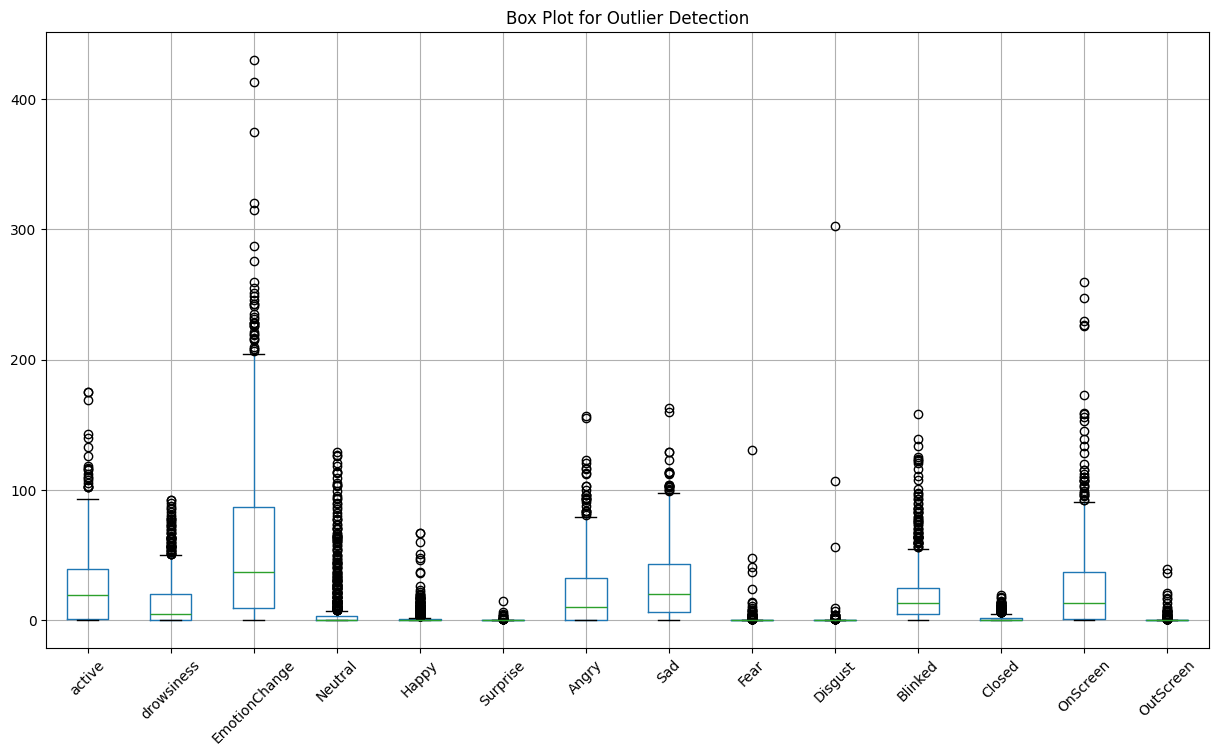

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('cleaned_data.csv')

# Plot box plots for each feature to visualize outliers
features = df.columns.drop(['SubjID', 'FileID', 'Minute', 'conLevel'])
df[features].boxplot(figsize=(15, 8), rot=45)
plt.title('Box Plot for Outlier Detection')
plt.show()

Robust Scailing

  SubjID  FileID  Minute  active  drowsiness  EmotionChange  Neutral  Happy  \
0   S001       1       1      17          16             47        5      0   
1   S001       1       2       1          16             40        7      0   
2   S001       1       3       0           1             52        4      0   
3   S001       1       4       0           2            100        1      0   
4   S001       2       1       3           8             88       14      0   

   Surprise  Angry  Sad  Fear  Disgust  Blinked  Closed  OnScreen  OutScreen  \
0         0     18   24     0        0       10       0         3        0.0   
1         0     11   22     0        0        7       0         0        0.0   
2         0     22   26     0        0        7       0         0        0.0   
3         0     48   51     0        0        9       0         0        0.0   
4         0     23   51     0        0       24       0         0        0.0   

   conLevel  
0       2.0  
1       2.0  
2 

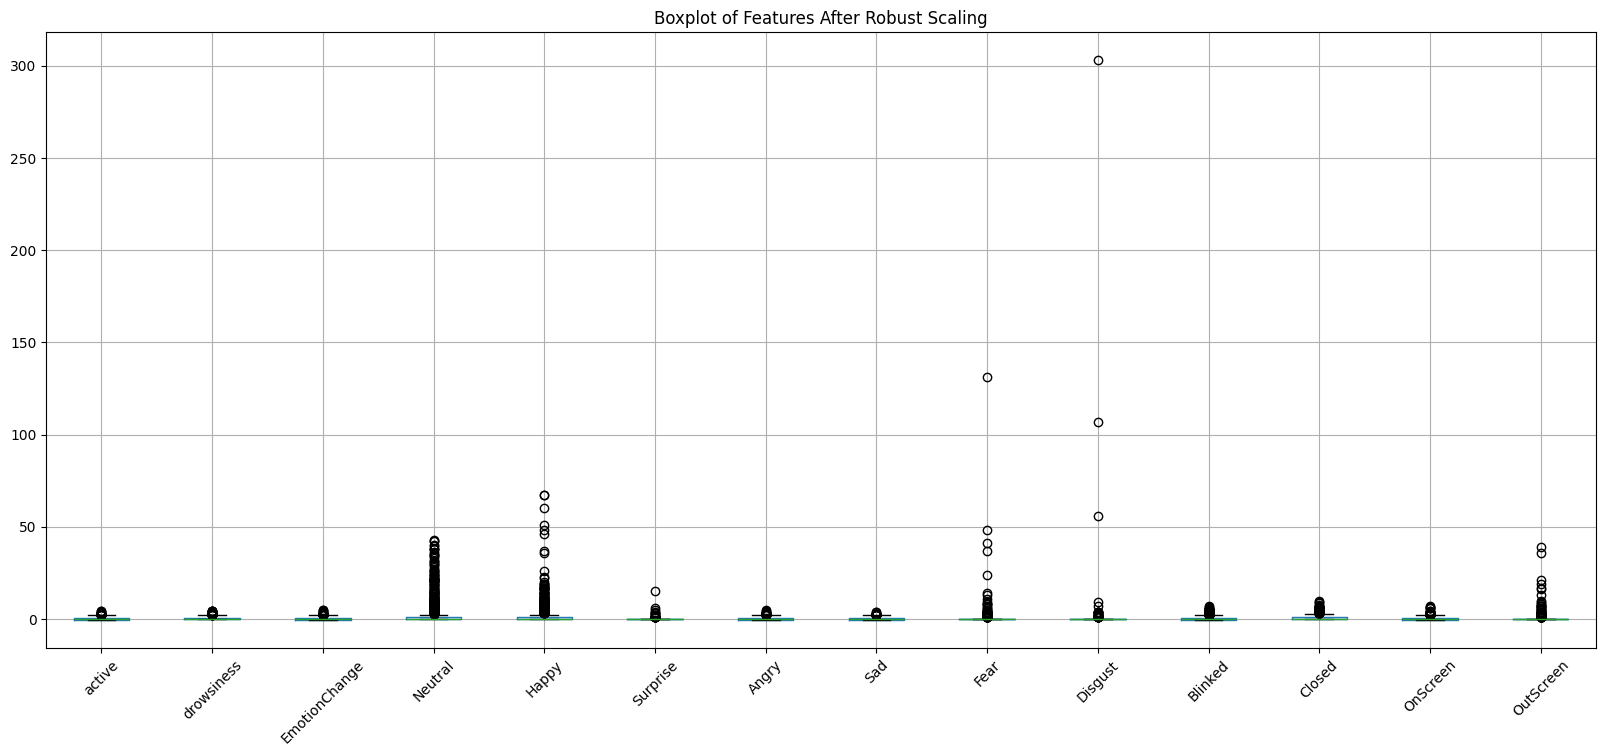

  SubjID  FileID  Minute    active  drowsiness  EmotionChange   Neutral  \
0   S001       1       1 -0.052632        0.55       0.128205  1.666667   
1   S001       1       2 -0.473684        0.55       0.038462  2.333333   
2   S001       1       3 -0.500000       -0.20       0.192308  1.333333   
3   S001       1       4 -0.500000       -0.15       0.807692  0.333333   
4   S001       2       1 -0.421053        0.15       0.653846  4.666667   

   Happy  Surprise    Angry       Sad  Fear  Disgust  Blinked  Closed  \
0    0.0       0.0  0.25000  0.108108   0.0      0.0    -0.15     0.0   
1    0.0       0.0  0.03125  0.054054   0.0      0.0    -0.30     0.0   
2    0.0       0.0  0.37500  0.162162   0.0      0.0    -0.30     0.0   
3    0.0       0.0  1.18750  0.837838   0.0      0.0    -0.20     0.0   
4    0.0       0.0  0.40625  0.837838   0.0      0.0     0.55     0.0   

   OnScreen  OutScreen  conLevel  
0 -0.277778        0.0       2.0  
1 -0.361111        0.0       2.0  
2 -0.

In [13]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sn

# Load the dataset
df = pd.read_csv('cleaned_data.csv')

# Display the first few rows to verify
print(df.head())
# Select features to scale (exclude SubjID, FileID, Minute, and conLevel)
features_to_scale = df.columns.drop(['SubjID', 'FileID', 'Minute', 'conLevel'])

# Initialize RobustScaler
scaler = RobustScaler()

# Apply scaling
df_scaled = df.copy()  # Create a copy of the original dataframe
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])
plt.figure(figsize=(20, 8))
df_scaled[features].boxplot()
plt.title("Boxplot of Features After Robust Scaling")
plt.xticks(rotation=45)
plt.show()
# Display the scaled data
print(df_scaled.head())
df_scaled.to_csv('scaled_data.csv', index=False)

Feature Selection by correlation analysis (Pearson)

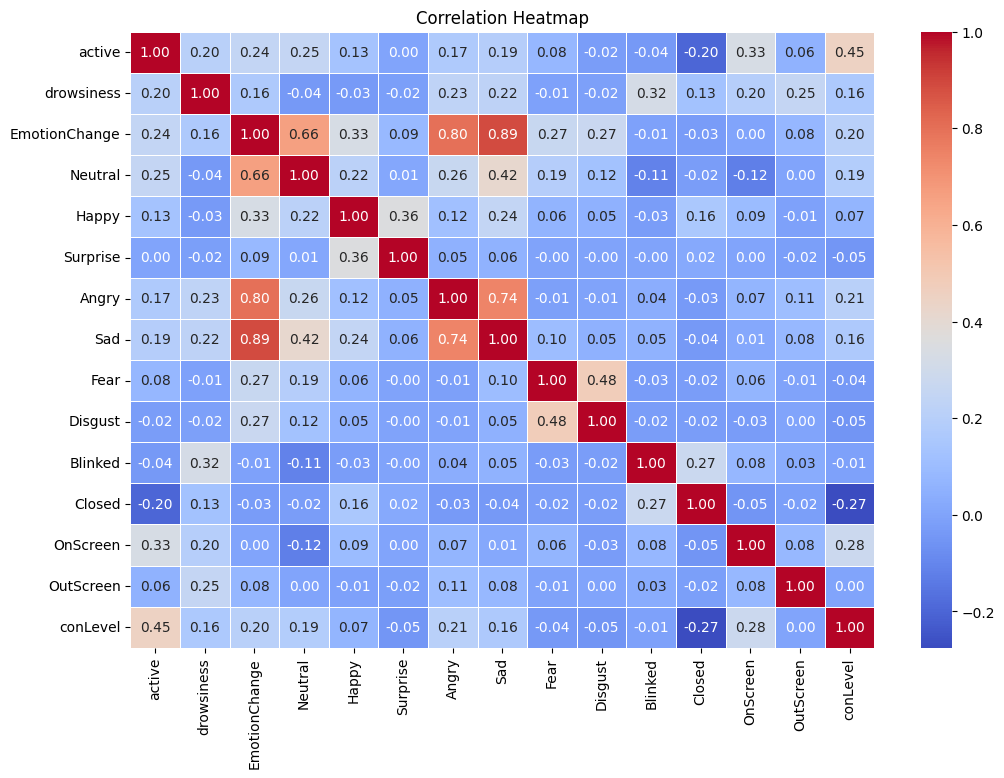

Selected features based on correlation (>= 0.2):
['active', 'EmotionChange', 'Angry', 'Closed', 'OnScreen']
active           0
EmotionChange    0
Blinked          0
Closed           0
OnScreen         0
OutScreen        0
conLevel         0
dtype: int64
Features after dropping: ['active', 'EmotionChange', 'Blinked', 'Closed', 'OnScreen', 'OutScreen']
Shape of X: (976, 6), y: (976,)


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('scaled_data.csv')
# Drop identifier columns before correlation analysis
df = df.drop(columns=['SubjID', 'FileID', 'Minute'])

# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Find correlation of each feature with 'conLevel'
target_correlation = correlation_matrix['conLevel'].drop(['conLevel'])
selected_features = target_correlation[abs(target_correlation) >= 0.2].index.tolist()

print("Selected features based on correlation (>= 0.2):")
print(selected_features)

selected_features = ['active', 'EmotionChange', 'Blinked', 'Closed', 'OnScreen', 'OutScreen', 'conLevel']
df_selected = df[selected_features]
# Check for missing values
print(df_selected.isnull().sum())

# Drop rows with missing values (if any)
df_selected = df_selected.dropna()

# List of features to drop
features_to_drop = ['drowsiness', 'Neutral', 'Happy','Surprise','Angry','Sad','Fear','Disgust']

# Drop insignificant features from the DataFrame
df_significant = df.drop(columns=features_to_drop)

# Separate features (X) and target (y)
X = df_significant.drop(columns='conLevel')  # Features
y = df_significant['conLevel']  # Target

# Check the resulting DataFrame
print(f"Features after dropping: {X.columns.tolist()}")
print(f"Shape of X: {X.shape}, y: {y.shape}")
df_significant.to_csv('selected_features_data.csv', index=False)

Oversampling with SMOTE

In [36]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

df = pd.read_csv('selected_features_data.csv')

# Separate features and target
X = df.drop(columns='conLevel')
y = df['conLevel']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"After SMOTE: X_resampled shape: {X_resampled.shape}, y_resampled shape: {y_resampled.shape}")

# Combine X_resampled and y_resampled into a single DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Save to a CSV file
df_resampled.to_csv('resampled_dataset.csv', index=False)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")
print("Resampled dataset saved as 'resampled_dataset.csv'")

After SMOTE: X_resampled shape: (1348, 6), y_resampled shape: (1348,)
Class distribution after SMOTE: Counter({2.0: 337, 1.0: 337, 3.0: 337, 0.0: 337})
Resampled dataset saved as 'resampled_dataset.csv'


In [37]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('resampled_dataset.csv')
# Separate features and target
X = df_selected.drop(columns='conLevel')  # Features
y = df_selected['conLevel']  # Target
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shape of the resulting sets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Training set: (780, 6), (780,)
Testing set: (196, 6), (196,)


Let's Train LeSA

In [ ]:
!pip3 install xgboost==1.7.6
!pip3 install scikit-learn==1.3.1
!pip3 install lightgbm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load dataset
df = pd.read_csv('resampled_dataset.csv')  # Ensure this is your SMOTE-resampled dataset
X = df.drop(columns='conLevel')
y = df['conLevel']

# Initialize models
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Evaluation metrics
scoring = {
    'Precision': make_scorer(precision_score, average='weighted'),
    'Recall': make_scorer(recall_score, average='weighted'),
    'F1-Score': make_scorer(f1_score, average='weighted'),
    'ROC-AUC': 'roc_auc_ovo'
}

# Cross-validation setup
cv_folds = [10, 20, 30]  # List of different cross-validation folds to test
results = []

# Training and evaluation
for model_name, model in models.items():
    print(f"Training {model_name}...")
    for cv in cv_folds:
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        start_time = time.time()
        
        scores = cross_val_score(model, X, y, cv=skf, scoring='f1_weighted')
        end_time = time.time()
        latency = end_time - start_time
        
        result = {
            'Model': model_name,
            'CV Folds': cv,
            'Precision': np.mean(cross_val_score(model, X, y, cv=skf, scoring=scoring['Precision'])),
            'Recall': np.mean(cross_val_score(model, X, y, cv=skf, scoring=scoring['Recall'])),
            'F1-Score': np.mean(scores),
            'ROC-AUC': np.mean(cross_val_score(model, X, y, cv=skf, scoring=scoring['ROC-AUC'])),
            'Latency (s)': latency
        }
        results.append(result)
        print(f"Done: {result}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df)

# Save results to CSV
results_df.to_csv('model_performance_comparison.csv', index=False)


Fine Tuning Hyperparameter

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score

# Load dataset
df = pd.read_csv('resampled_dataset.csv')
X = df.drop(columns='conLevel')
y = df['conLevel']

# Cross-validation setup
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# Define hyperparameter grids for each model
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    },
    'Logistic Regression': {
        'penalty': ['l2'],
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [100, 500, 1000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'max_depth': [-1, 10, 20]
    }
}

# Initialize models
models = {
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Initialize result storage
best_params = {}
best_scores = {}

# Perform hyperparameter tuning using RandomizedSearchCV
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids[model_name]
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        scoring=make_scorer(f1_score, average='weighted'),
        cv=skf,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X, y)
    
    # Store the best parameters and score
    best_params[model_name] = random_search.best_params_
    best_scores[model_name] = random_search.best_score_
    
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Best F1-Score for {model_name}: {random_search.best_score_:.4f}")

# Display final results
print("\nHyperparameter Tuning Results:")
for model_name in best_params:
    print(f"{model_name}: Best Params = {best_params[model_name]}, Best F1-Score = {best_scores[model_name]:.4f}")


c:\Users\picha\.conda\envs\LeSA\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Tuning hyperparameters for SVM...
Fitting 20 folds for each of 20 candidates, totalling 400 fits
Best parameters for SVM: {'kernel': 'rbf', 'gamma': 1, 'C': 100}
Best F1-Score for SVM: 0.6399
Tuning hyperparameters for Logistic Regression...
Fitting 20 folds for each of 20 candidates, totalling 400 fits
Best parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'C': 0.1}
Best F1-Score for Logistic Regression: 0.4828
Tuning hyperparameters for Random Forest...
Fitting 20 folds for each of 20 candidates, totalling 400 fits
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best F1-Score for Random Forest: 0.6520
Tuning hyperparameters for Gradient Boosting...
Fitting 20 folds for each of 20 candidates, totalling 400 fits
Best parameters for Gradient Boosting: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2}
Best F1-Score for Gradient Boosting: 0.6289
Tuning hyperparamete

c:\Users\picha\.conda\envs\LeSA\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\picha\.conda\envs\LeSA\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}
Best F1-Score for XGBoost: 0.6296
Tuning hyperparameters for LightGBM...
Fitting 20 folds for each of 20 candidates, totalling 400 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1080
[LightGBM] [Info] Number of data points in the train set: 1348, number of used features: 6
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

Re-train with fine tune parameter

In [12]:
!pip3 install xgboost lightgbm

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 1.2 MB/s eta 0:01:44
   ---------------------------------------- 1.0/124.9 MB 1.4 MB/s eta 0:01:29
    --------------------------------------- 1.6/124.9 MB 1.6 MB/s eta 0:01:20
    --------------------------------------- 2.1/124.9 MB 1.7 MB/s eta 0:01:12
    --------------------------------------- 2.6/124.9 MB 1.9 MB/s eta 0:01:06
   - -------------------------------------- 3.1/124.9 MB 2.0 MB/s eta 0:01:01
   - -------------------------------------- 3.9/124.9 MB 2.2 MB/s eta 0:00:57
   - -------------------------------------- 4.5/124.9 MB 2.3 MB/s eta 0:00:53
   - -----------------


Training SVM...
SVM - Precision: 0.6059, Recall: 0.6148, F1-Score: 0.6055, ROC-AUC: 0.8348, Latency: 0.34s

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83        68
         1.0       0.61      0.46      0.53        67
         2.0       0.50      0.49      0.49        68
         3.0       0.57      0.58      0.57        67

    accuracy                           0.61       270
   macro avg       0.61      0.61      0.61       270
weighted avg       0.61      0.61      0.61       270



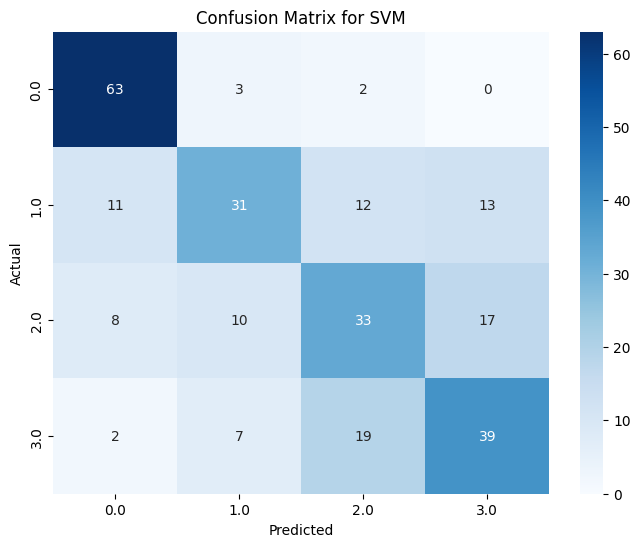


Training Logistic Regression...
Logistic Regression - Precision: 0.5068, Recall: 0.5296, F1-Score: 0.4969, ROC-AUC: 0.7681, Latency: 0.03s

Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.97      0.77        68
         1.0       0.49      0.27      0.35        67
         2.0       0.43      0.29      0.35        68
         3.0       0.46      0.58      0.52        67

    accuracy                           0.53       270
   macro avg       0.51      0.53      0.50       270
weighted avg       0.51      0.53      0.50       270



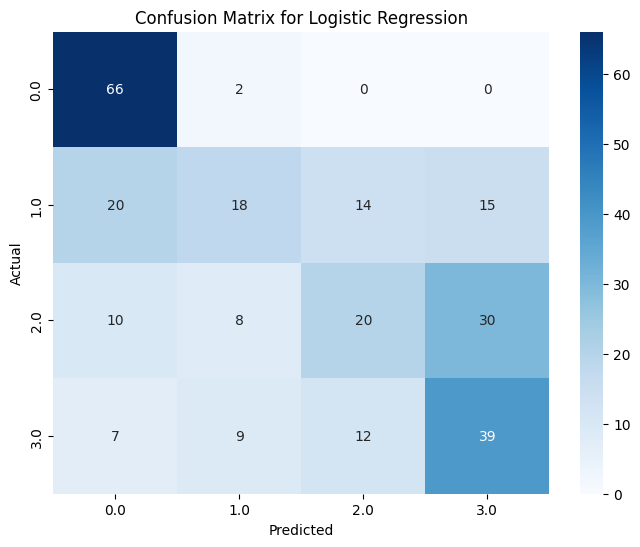


Training Random Forest...
Random Forest - Precision: 0.6333, Recall: 0.6407, F1-Score: 0.6345, ROC-AUC: 0.8678, Latency: 0.65s

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86        68
         1.0       0.70      0.63      0.66        67
         2.0       0.49      0.50      0.50        68
         3.0       0.55      0.49      0.52        67

    accuracy                           0.64       270
   macro avg       0.63      0.64      0.63       270
weighted avg       0.63      0.64      0.63       270



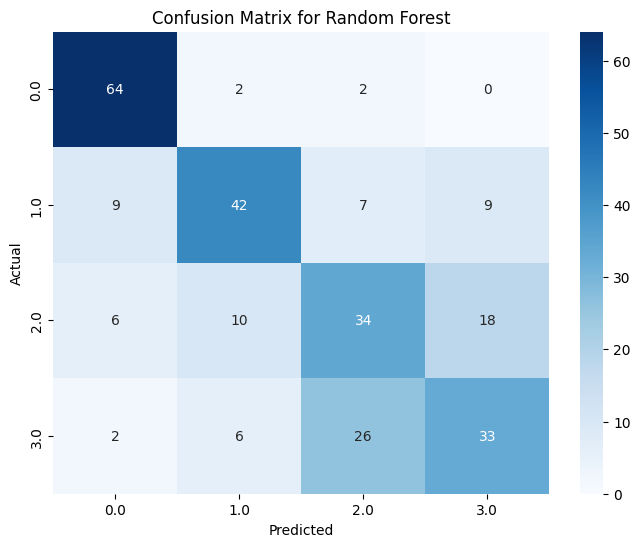


Training Gradient Boosting...
Gradient Boosting - Precision: 0.6299, Recall: 0.6370, F1-Score: 0.6295, ROC-AUC: 0.8532, Latency: 6.89s

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86        68
         1.0       0.69      0.63      0.66        67
         2.0       0.49      0.54      0.52        68
         3.0       0.55      0.43      0.48        67

    accuracy                           0.64       270
   macro avg       0.63      0.64      0.63       270
weighted avg       0.63      0.64      0.63       270



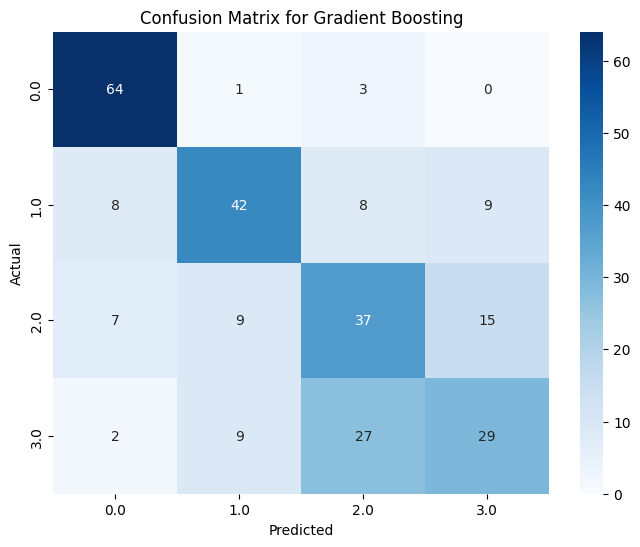


Training XGBoost...


c:\Users\picha\.conda\envs\LeSA\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Precision: 0.5989, Recall: 0.6074, F1-Score: 0.6007, ROC-AUC: 0.8479, Latency: 0.95s

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88        68
         1.0       0.65      0.55      0.60        67
         2.0       0.46      0.46      0.46        68
         3.0       0.48      0.46      0.47        67

    accuracy                           0.61       270
   macro avg       0.60      0.61      0.60       270
weighted avg       0.60      0.61      0.60       270



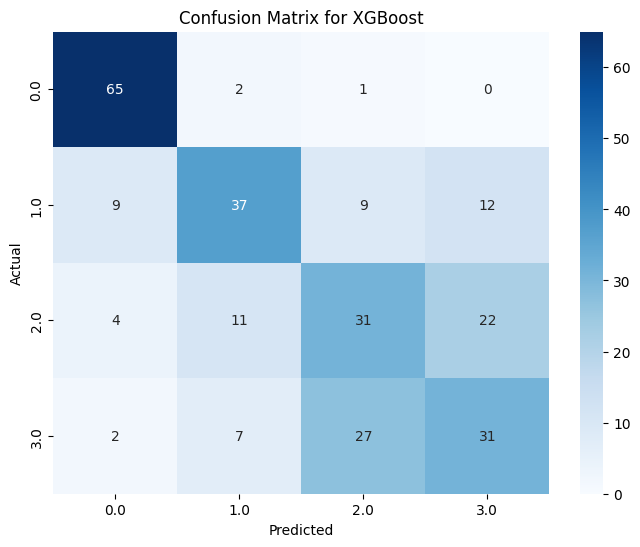


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 6
[LightGBM] [Info] Start training from score -1.388151
[LightGBM] [Info] Start training from score -1.384441
[LightGBM] [Info] Start training from score -1.388151
[LightGBM] [Info] Start training from score -1.384441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

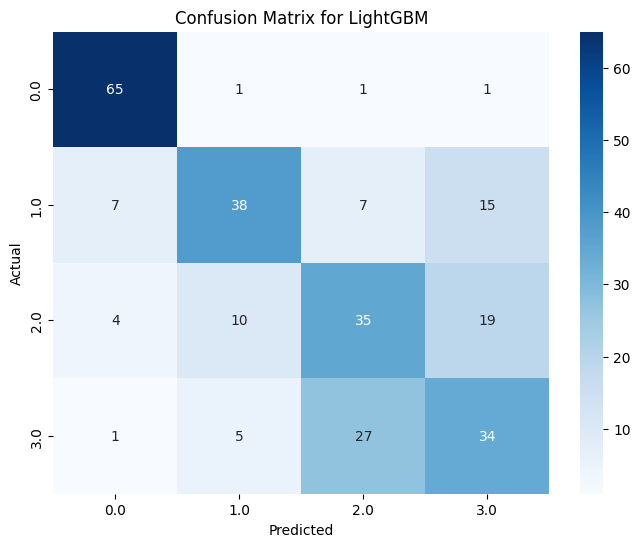


Final Evaluation Results:
                 Model  Precision    Recall  F1-Score   ROC-AUC  Latency (s)
0                  SVM   0.605908  0.614815  0.605522  0.834759     0.336001
1  Logistic Regression   0.506814  0.529630  0.496861  0.768083     0.029176
2        Random Forest   0.633280  0.640741  0.634451  0.867837     0.646605
3    Gradient Boosting   0.629876  0.637037  0.629470  0.853229     6.889651
4              XGBoost   0.598871  0.607407  0.600679  0.847859     0.951006
5             LightGBM   0.635427  0.637037  0.633485  0.847830     1.237144


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load dataset
df = pd.read_csv('resampled_dataset.csv')
X = df.drop(columns='conLevel')
y = df['conLevel']

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Best hyperparameters from tuning (replace with your actual best params)
best_params = {
    'SVM': {'C': 10, 'gamma': 1, 'kernel': 'rbf'},
    'Logistic Regression': {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs', 'max_iter': 100},
    'Random Forest': {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1},
    'Gradient Boosting': {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 7},
    'XGBoost': {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 7, 'subsample': 0.8},
    'LightGBM': {'n_estimators': 300, 'learning_rate': 0.2, 'num_leaves': 50, 'max_depth': -1}
}

# Initialize models with best parameters
models = {
    'SVM': SVC(probability=True, random_state=42, **best_params['SVM']),
    'Logistic Regression': LogisticRegression(random_state=42, **best_params['Logistic Regression']),
    'Random Forest': RandomForestClassifier(random_state=42, **best_params['Random Forest']),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, **best_params['Gradient Boosting']),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='mlogloss', **best_params['XGBoost']),
    'LightGBM': LGBMClassifier(random_state=42, **best_params['LightGBM'])
}

# Evaluation metrics
results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    latency = end_time - start_time
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')
    
    print(f"{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, Latency: {latency:.2f}s")
    
    results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Latency (s)': latency
    })
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Convert results to DataFrame and save
results_df = pd.DataFrame(results)
print("\nFinal Evaluation Results:")
print(results_df)

# Save results to CSV
results_df.to_csv('final_model_evaluation.csv', index=False)


Save Model

In [2]:
!pip3 install joblib

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [2]:
import pickle
from sklearn.ensemble import RandomForestClassifier
# Assume Gradient Boosting was the best model based on evaluation (replace with your best model)
best_model_name = 'Random Forest'
best_model = models[best_model_name]

# Save the model
model_save_path = 'models/LeSA.pkl'
# ✅ Save it correctly
with open(model_save_path, "wb") as model_file:
    pickle.dump(best_model, model_file)